# Исследование продаж компьютерных игр

**Описание проекта:**

Мы работаем в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируем ли мы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

**Описание данных "games.csv":**

* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Данные за 2016 год могут быть неполными.

## Изучение данных

Сначала импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
from matplotlib import pyplot as plt

Загрузим датасет:

In [2]:
games = pd.read_csv('games.csv')

Осмотрим датасет и информацию о нем:

In [3]:
games.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


**Выводы:**

Мы изучили данные и нашли следующие ошибки и аномалии:

1. Названия столбцов написаны в разных регистрах.
2. Столбец Year_of_Release - требуется поменять тип данных на int.
3. Столбец User_Score - требуется поменять тип данных на вещественный.
4. Обнаружены пропуски в столбцах: Name, Year_of_Release, Genre, Critic_Score, User_Score и Rating.

## Предобработка данных

Приступим к подготовке данных для дальнейшего анализа.

Начнем с того, что приведем названия столбцов к нижнему регистру.

In [5]:
games.columns = games.columns.str.lower()

Поменяем тип данных в столбце year_of_release:

In [6]:
games['year_of_release'] = games['year_of_release'].astype('Int64')

Повнимательнее посмотрим, какие значения есть в столбце user_score:

In [7]:
games['user_score'].value_counts(dropna=False)

NaN    6701
tbd    2424
7.8     324
8       290
8.2     282
       ... 
1.1       2
1.9       2
9.6       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

Мы наблюдаем здесь странное значение tbd. В геймдеве это обозначает "To Be Determined" - "Еще Не Определено". Эта абревиатура равноценна пустому значению, потому мы можем спокойно заменить ее на NaN.

In [8]:
games['user_score'] = games['user_score'].replace('tbd', np.nan, regex=True)

Теперь нам ничего не мешает поменять тип данных в столбце user_score на вещественный:

In [9]:
games['user_score'] = games['user_score'].astype('float64')

Теперь обработаем пропуски.

Сначала столбец year_of_release.

Посмотрим, сколько здесь пропусков.

In [10]:
games['year_of_release'].isnull().sum()

269

Причина присутствия пропусков в столбце о дате выхода игры не совсем понятна. В виду их маленького количества, их можно свести к человеческому фактору. Может быть просто забыли внести.  

Можно предположить, что некоторые игры с неуказанным годом выпускались и на других платформах, где год выпуска указан. Стоит проверить. 

Посмотрим список игр с пустыми значениями года выпуска:

In [11]:
games[games['year_of_release'].isnull()].head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,<NA>,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,<NA>,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,<NA>,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,<NA>,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN


Возьмем первую игру в списке, и проверим наше предположение:

In [12]:
games.query('name == "Madden NFL 2004"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
183,Madden NFL 2004,PS2,<NA>,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
1881,Madden NFL 2004,XB,2003,Sports,1.02,0.02,0.00,0.05,92.0,8.3,E
3889,Madden NFL 2004,GC,2003,Sports,0.40,0.10,0.00,0.01,94.0,7.7,E
5708,Madden NFL 2004,GBA,2003,Sports,0.22,0.08,0.00,0.01,70.0,6.6,E


Предположение подтвердилось. С помощью цикла подставим год выпуска для других подобных игр:

In [13]:
for i in games[games['year_of_release'].isnull() == True].index:  
    games['year_of_release'][i] = games.loc[games['name'] == games['name'][i], 'year_of_release'].max()

Посмотрим, сколько пустых значений осталось после цикла:

In [14]:
games['year_of_release'].isnull().sum()

146

Все пропуски таким образом заполнить не удалось. В виду их маленького числа, мы можем оставшиеся строки просто удалить из таблицы:

In [15]:
games = games.dropna(subset=['year_of_release']).reset_index(drop=True)

Теперь осмотрим столбцы critic_score и user_score.

In [16]:
games['critic_score'].describe()

count    8075.000000
mean       68.991950
std        13.923383
min        13.000000
25%        60.000000
50%        71.000000
75%        79.000000
max        98.000000
Name: critic_score, dtype: float64

In [17]:
games['user_score'].describe()

count    7540.000000
mean        7.125027
std         1.498254
min         0.000000
25%         6.400000
50%         7.500000
75%         8.200000
max         9.700000
Name: user_score, dtype: float64

Посчитаем количество пропущенных значений:

In [18]:
games['critic_score'].isnull().sum()

8494

In [19]:
games['user_score'].isnull().sum()

9029

Очень много пропусков. Это можно объяснить тремя причинами:

1. Ставить оценки по десятибальной (или пятибальной) шкале вошло в моду только во второй половине девяностых. Слишком старые игры попросту не имеют зафиксированной оценки.
2. Игры со слишком маленьким числом продаж могли пройти совершенно незаметно для критиков и общей публики, таким образом не получив общепринятой оценки.
3. Игры, которые вышли к концу временного периода данных из таблицы (в конце 2016-го года) могли просто не успеть получить должную оценку. 

В любом случае, число пропусков слишком велико, чтобы их просто удалить. Мы видим, что минимальное значение в этих столбцах равно 0. Потому замена пропусков на 0 будет не корректным исправлением. Поскольку оценки критиков и пользователей - сугубо субьективная оценка, заполнить пропуски медианой или средним значением тоже невозможно. Потому пропуски в этих столбцах решено было оставить, как есть.

Осмотрим столбец rating:

In [20]:
games['rating'].value_counts(dropna=False)

NaN     6701
E       3958
T       2930
M       1554
E10+    1412
EC         8
K-A        3
RP         2
AO         1
Name: rating, dtype: int64

Количество пропусков здесь практически такое же большое, как и в столбцах critic_score и user_score. Это можно объяснить тем, что рейтинг ESRB - американская система оценки игр, и потому те игры, которые не выпускались на американском рынке попросту не прошли оценку.

Удалять эти пропуски будет не верным решением. Но поскольку эти пустые значения потребуется учесть в дальнейшем исследовании, заполним пропуски в этом столбце абревиатурой NR (No Rating), обозначив таким образом, что игра не прошла оценку ESRB.

In [21]:
games['rating'] = games['rating'].fillna('NR')

Напоследок обработаем пропуски в столбцах name и genre. Объяснить пропуски в этих местах можно только человеческим фактором. Поскольку их очень небольшое количество, мы можем попросту удалить эти строки без вреда для будущего анализа:

In [22]:
games = games.dropna(subset=['name', 'genre']).reset_index(drop=True)

Теперь, проверим столбцы на присутствие дубликатов.

Конкретнее, нас интересуют столбцы name и platform.

In [23]:
games[games.duplicated(subset=['name', 'platform'], keep=False)]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
603,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
1184,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1582,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1736,Sonic the Hedgehog,PS3,2006,Platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+
4106,Sonic the Hedgehog,PS3,2006,Platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+
5931,Need for Speed: Most Wanted,PC,2005,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
11624,Need for Speed: Most Wanted,PC,2012,Racing,0.00,0.06,0.00,0.02,82.0,8.5,T
16087,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E


Мы видим, что некоторые игры повторяются в списке для одних и тех же платформ. Почему?

Поискав информацию в интернете, можно обнаружить, что Need for Speed: Most Wanted перезапускалась повторно другой студией в 2012 году. Технически, эти дубликаты можно считать двумя отдельными играми, и потому убирать их не стоит.

Что касается Madden MFL 13 и Sonic the Hedgehog, здесь сказать трудно. Мы видим, что продажи у дубликатов зафиксированы только в районе EU, и в весьма маленьких количествах. Это может быть как технической ошибкой, так и человеческим фактором. Поскольку это весьма крохотный объем данных, я думаю, мы можем просто удалить строчки с этими дубликатами без вреда для будущего исследования.

Удалим строчки с теми дубликатами, где меньше продаж, а именно строки с индексами 4106 и 16087:

In [24]:
games = games.drop([4106, 16087]).reset_index(drop=True)

Наконец добавим новый столбец с общими продажами:

In [25]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

Просмотрим датасет со внесенными изменениями:

In [26]:
games.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NR,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NR,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NR,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NR,28.31


In [27]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16565 entries, 0 to 16564
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16565 non-null  object 
 1   platform         16565 non-null  object 
 2   year_of_release  16565 non-null  Int64  
 3   genre            16565 non-null  object 
 4   na_sales         16565 non-null  float64
 5   eu_sales         16565 non-null  float64
 6   jp_sales         16565 non-null  float64
 7   other_sales      16565 non-null  float64
 8   critic_score     8073 non-null   float64
 9   user_score       7538 non-null   float64
 10  rating           16565 non-null  object 
 11  total_sales      16565 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.5+ MB


**Выводы:**

В процессе предобработки данных, мы внесли в таблицу следующие изменения:

1. year_of_release - тип данных поменяли на int.
2. user_score - заменили tbd на NaN, и тип данных поменяли на float.
3. Удалили пропущенные значения в столбцах name, genre, year_of_release.
4. Удалили неявные дубликаты в 4106 и 16087 строках. 
4. Добавили столбец total_sales с суммарными продажами во всех регионах.

## Исследовательский анализ данных

### Число выпускаемых игр в разные годы

C:\Users\Taras\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Количество выпущенных игр')

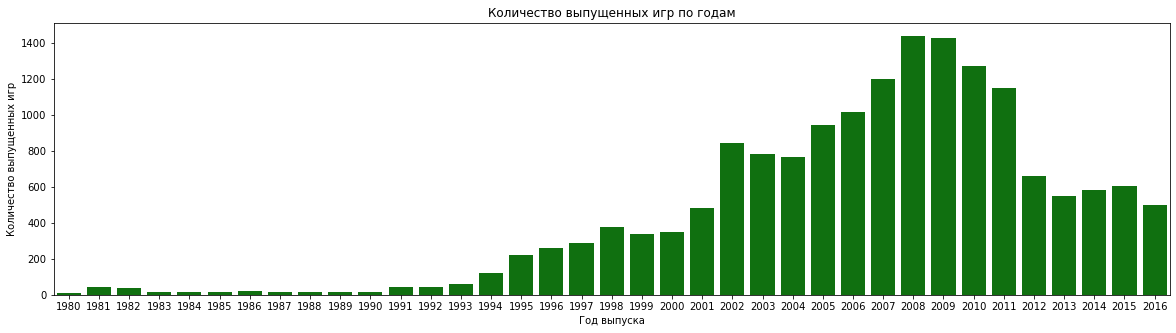

In [28]:
plt.figure(figsize=(20, 5))
sns.countplot(games.year_of_release, color='green')
plt.title("Количество выпущенных игр по годам")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")

Согласно наблюдаемому распределению, мы видим, что число продаваемых игр начало расти в 1993-м году, и достигло пика в 2008 г. После чего начался спад продаж, скорее всего из-за резкого развития и роста популярности мобильных игр. 

Можно сделать вывод, что данные по всем периодам нас не интересуют.

В период с 2013 по 2016 число продаж более-менее стабилизируется. Именно его мы и будем использовать для дальнейших исследований.

### Изменение продаж по платформам

Сначала составим сводную таблицу по платформам и их продажами.

In [29]:
sales_on_platform = games.pivot_table(index='platform', values='total_sales', aggfunc='sum') \
                    .sort_values(by='total_sales', ascending=False).reset_index()

Теперь составим по ней диаграмму:

Text(0.5, 1.0, 'Продажи по платформам за весь период')

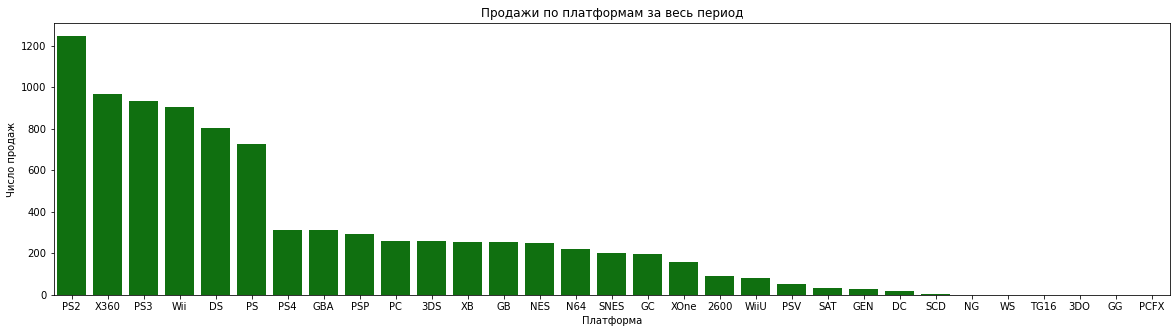

In [30]:
plt.figure(figsize=(20, 5))
sns.barplot(x=sales_on_platform.platform, y=sales_on_platform.total_sales, color = 'green')
plt.xlabel("Платформа")
plt.ylabel("Число продаж")
plt.title("Продажи по платформам за весь период")

Из диаграммы сверху видно, что самым большим числом продаж обладают платформы PS2, X360, PS3, Wii, DS и PS. 

Для дальнейших действий запишем их в отдельный список:

In [31]:
top_platforms_list = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

Построим распределение по годам для этих платформ. 

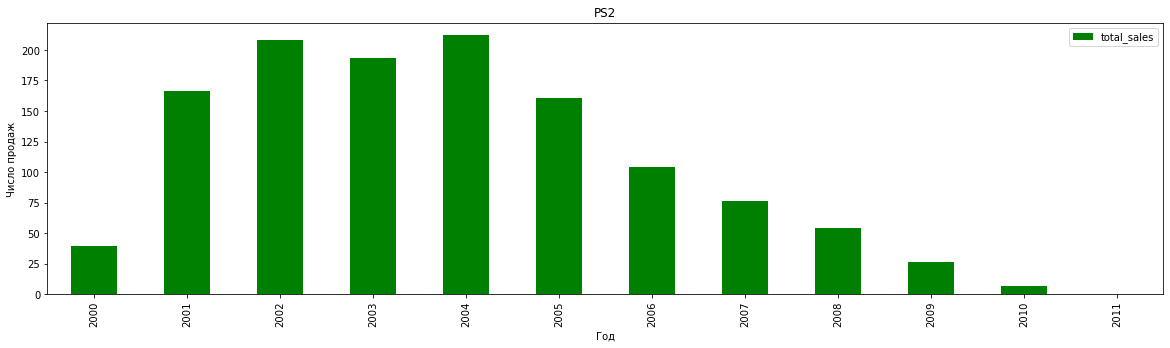

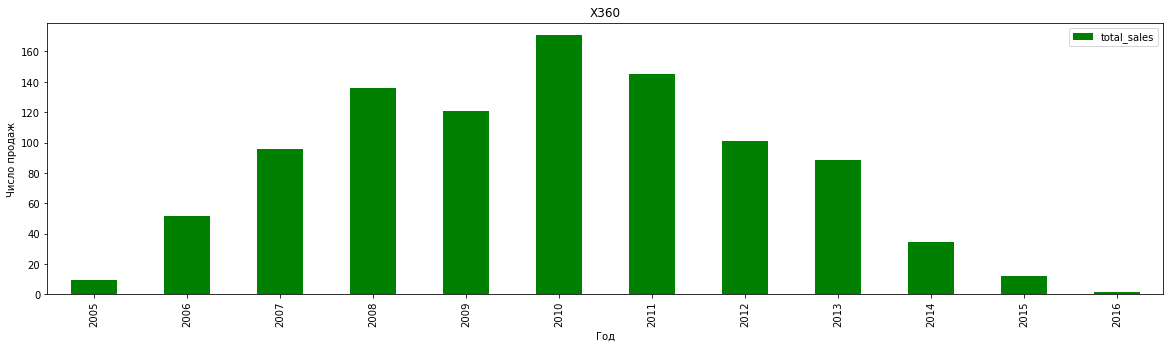

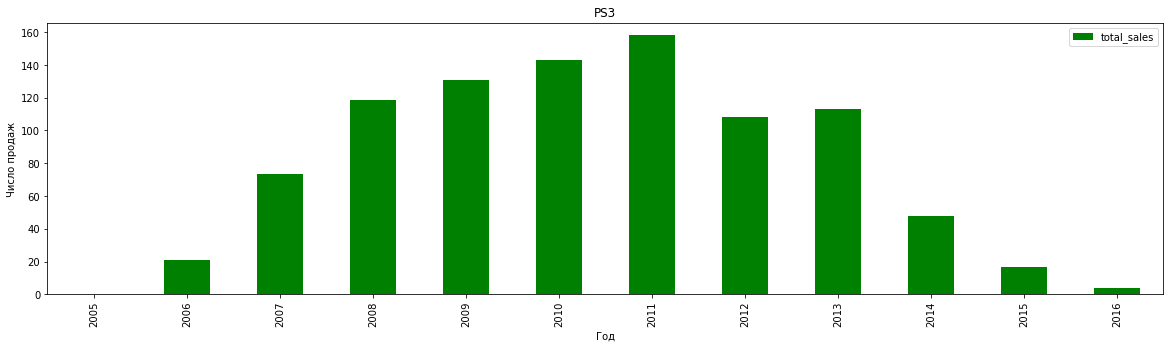

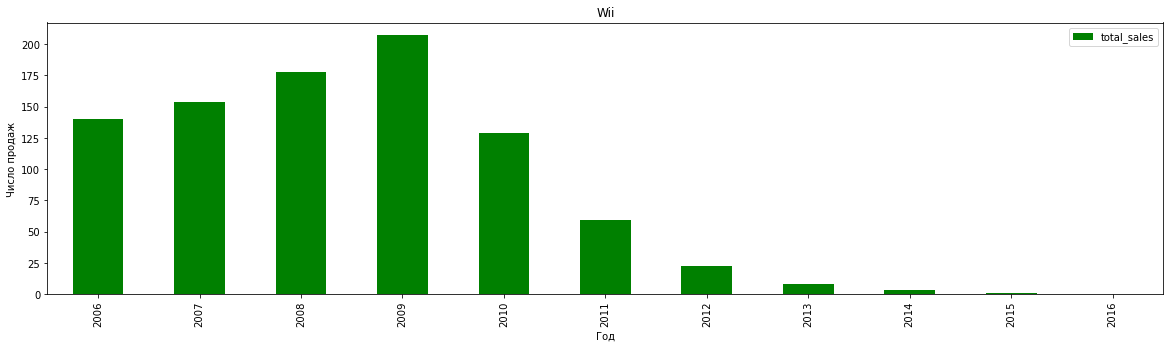

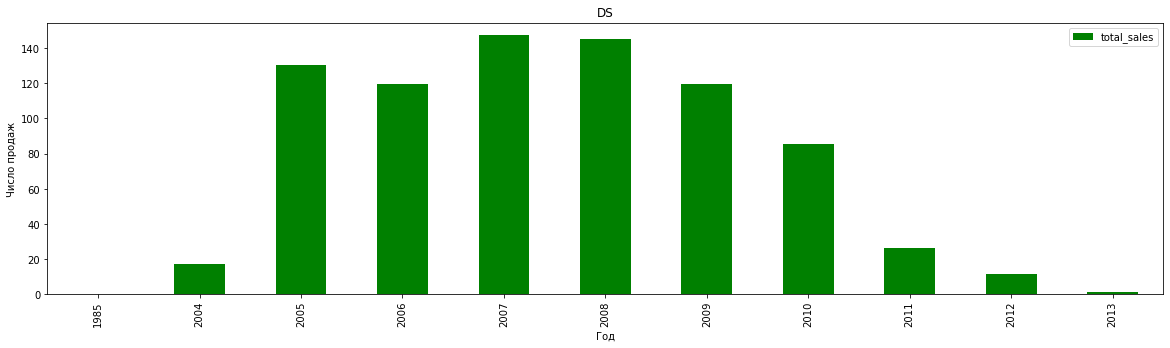

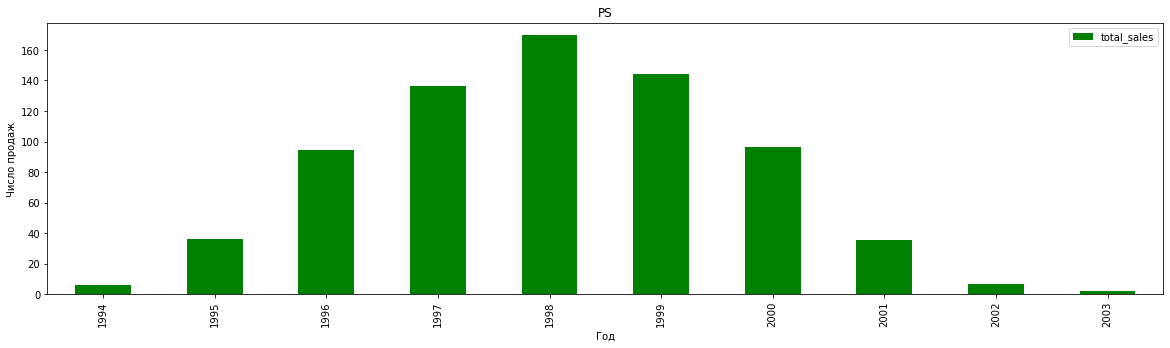

In [32]:
for platform in top_platforms_list:
    games[games['platform'] == platform].pivot_table(index='year_of_release', values='total_sales', aggfunc='sum').plot(
        kind='bar', figsize=(20,5), color='green')
    plt.title(platform)
    plt.xlabel('Год')
    plt.ylabel('Число продаж')

Посмотрим, сколько в среднем живут платформы.

Сначала составим таблицу с лидирующими платформами, затем вычтем самый ранний год выпуска из самого позднего для каждой из них, таким образом получив срок жизни каждой платформы:

In [33]:
top_platforms = games.query('platform in @top_platforms_list').reset_index()
platforms_lifespan = top_platforms.groupby('platform').agg({'year_of_release' : 'max'}) - top_platforms.groupby('platform').agg({'year_of_release' : 'min'}) 
display(platforms_lifespan)

,year_of_release
platform,
DS,28
PS,9
PS2,11
PS3,11
Wii,10
X360,11


Теперь посмотрим медиану этих значений. Среднее значение мы использовать не станем в виду присутствия очевидного выброса в виде платформы DS:

In [34]:
platforms_lifespan.median()

year_of_release    11.0
dtype: float64

Итого выходит, что обычно платформы живут по 11 лет.

### Исследование данных с 2013 по 2016 год

Для дальнейших исследований требуется определить актуальный временной период. Исходя из диаграмм и исследований, проведенных в предыдущих пунктах, в качестве актуального было решено определить период с 2013 по 2016 год.

Составим новый датасет, который будет включать данные только за этот период:

In [35]:
games_actual = games[games['year_of_release'] >= 2013].reset_index()
games_actual = games_actual.drop('index', 1)
display(games_actual)

C:\Users\Taras\AppData\Local\Temp/ipykernel_15944/1090257303.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  games_actual = games_actual.drop('index', 1)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
1,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NR,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NR,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
...,...,...,...,...,...,...,...,...,...,...,...,...
2232,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NR,0.01
2233,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,NaN,NaN,NR,0.01
2234,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,NaN,NR,0.01
2235,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NR,0.01


<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

Очень хорошо, что результат запроса/’среза’ ты присваиваешь новому датафрейму. Таким образом оригинальный датафрейм ты оставляешь нетронутым, не перезаписываешь (вдруг нам опять понадобятся данные из него чуть ниже). Это верное решение. Best practice. Молодец!</div>


Выведем общий доход по платформам за весь исследуемый период:

In [36]:
platform_total = games_actual.groupby('platform').agg({'total_sales': 'sum'}).sort_values(by = 'total_sales', ascending = False).reset_index()

display(platform_total)

,platform,total_sales
0,PS4,314.14
1,PS3,181.43
2,XOne,159.32
3,3DS,143.25
4,X360,136.80
5,WiiU,64.63
6,PC,40.06
7,PSV,32.99
8,Wii,13.66
9,PSP,3.74


Лидерами продаж являются PS4, PS3, XOne, 3DS и X360.

Чтобы подробнее исследовать прибыльность платформ, составим сводную таблицу для них по годам:

In [37]:
platform_per_year = games_actual.pivot_table(index=['platform','year_of_release'], values='total_sales', aggfunc='sum')

display(platform_per_year)

total_sales
platform year_of_release             
3DS      2013                   56.57
         2014                   43.76
         2015                   27.78
         2016                   15.14
DS       2013                    1.54
PC       2013                   12.66
         2014                   13.63
         2015                    8.52
         2016                    5.25
PS3      2013                  113.25
         2014                   47.76
         2015                   16.82
         2016                    3.60
PS4      2013                   25.99
         2014                  100.00
         2015                  118.90
         2016                   69.25
PSP      2013                    3.38
         2014                    0.24
         2015                    0.12
PSV      2013                   10.59
         2014                   11.90
         2015                    6.25
         2016                    4.25
Wii      2013                    8.59
         2014                    3.75
         2015                    1.14
         2016                    0.18
WiiU     2013                   21.65
         2014                   22.03
         2015                   16.35
         2016                    4.60
X360     2013                   88.58
         2014                   34.74
         2015                   11.96
         2016                    1.52
XOne     2013                   18.96
         2014                   54.07
         2015                   60.14
         2016                   26.15

Теперь мы видим, что скачки роста продаж есть только у PC, PS4, XOne, 3DS, WiiU и PSV. Именно они и являются самыми прибыльными на данный период. PS3, X360, Wii и PSP наоборот теряют в продажах. 

Игры на DS же вообще перестали выпускаться после 2013 года.

Это можно объяснить тем, что более новые версии платформ заменяют своих предшественников, предлагая игрокам более приятный опыт.

Для удобства внесем самые многообещающие платформы в отдельный список:

In [38]:
top_platforms_actual = ['PC', 'PS4', 'XOne', '3DS', 'WiiU', 'PSV']

Теперь составим "ящики с усами" для каждой из выбранных платформ.

Для этого создадим новый датафрейм, который будет включать в себя только данные по интересующим нас платформам:

In [39]:
top_platforms_data = games_actual[games_actual['platform'].isin(top_platforms_actual)]

display(top_platforms_data.head(5))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NR,14.63
3,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,NaN,NaN,NR,14.60
4,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
5,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,NR,11.68
9,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58


Теперь нарисуем ящики, используя данные из датафрейма:

Text(0, 0.5, 'Число продаж')

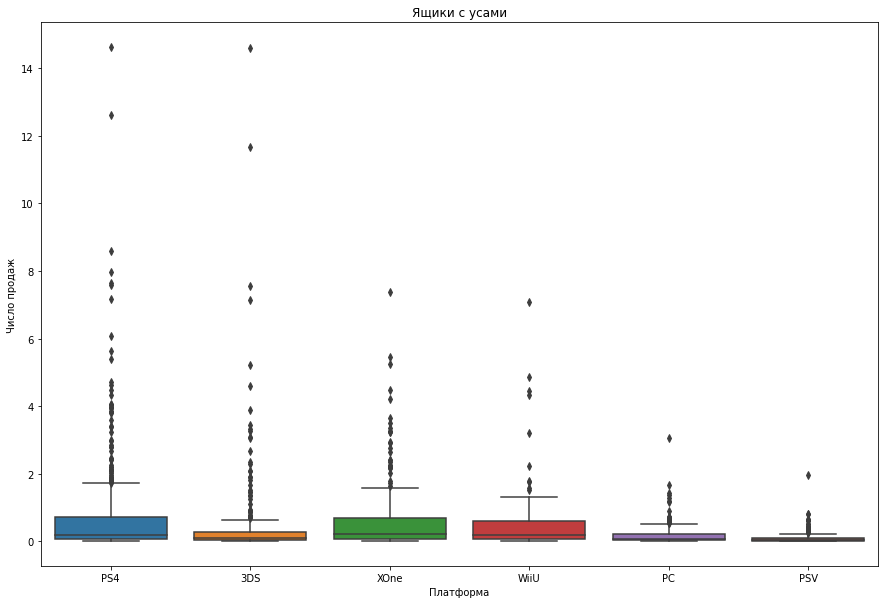

In [40]:
plt.figure(figsize=(15,10))
sns.boxplot(data=top_platforms_data, x='platform', y='total_sales')
plt.title('Ящики с усами')
plt.xlabel('Платформа')
plt.ylabel('Число продаж')

Сделаем вторую версию графика, обрезав выбросы, чтобы рассмотреть ящики детальнее:

Text(0, 0.5, 'Число продаж')

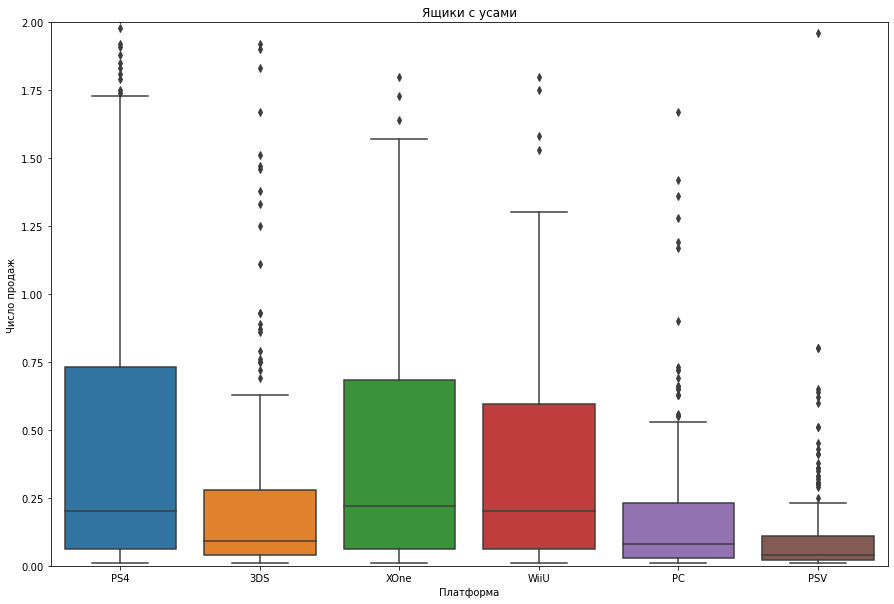

In [41]:
plt.figure(figsize=(15,10))
sns.boxplot(data=top_platforms_data, x='platform', y='total_sales')
plt.ylim(0, 2)
plt.title('Ящики с усами')
plt.xlabel('Платформа')
plt.ylabel('Число продаж')

Изучим все эти платформы повнимательнее:

In [42]:
for plat in top_platforms_actual:
    platform_description = games_actual[games_actual['platform']==plat]
    print('Платформа', plat)
    print(platform_description['total_sales'].describe())
    print('')

Платформа PC
count    192.000000
mean       0.208646
std        0.349801
min        0.010000
25%        0.030000
50%        0.080000
75%        0.230000
max        3.050000
Name: total_sales, dtype: float64

Платформа PS4
count    392.000000
mean       0.801378
std        1.609456
min        0.010000
25%        0.060000
50%        0.200000
75%        0.730000
max       14.630000
Name: total_sales, dtype: float64

Платформа XOne
count    247.000000
mean       0.645020
std        1.036139
min        0.010000
25%        0.060000
50%        0.220000
75%        0.685000
max        7.390000
Name: total_sales, dtype: float64

Платформа 3DS
count    303.000000
mean       0.472772
std        1.381347
min        0.010000
25%        0.040000
50%        0.090000
75%        0.280000
max       14.600000
Name: total_sales, dtype: float64

Платформа WiiU
count    115.000000
mean       0.562000
std        1.038778
min        0.010000
25%        0.060000
50%        0.200000
75%        0.595000
max      

**Выводы:**

1. Среднее число продаж на PC на одну игру составляет 208 тыс. копий. Максимальное число продаж: 3.1 млн. копий.
2. Среднее число продаж на PS4 на одну игру составляет 801 тыс. копий. Максимальное число продаж: 14.6 млн. копий.
3. Среднее число продаж на XOne на одну игру составляет 645 тыс. копий. Максимальное число продаж: 7.4 млн. копий.
4. Среднее число продаж на 3DS на одну игру составляет 472 тыс. копий. Максимальное число продаж: 14.6 млн. копий.
5. Среднее число продаж на WiiU на одну игру составляет 562 тыс. копий. Максимальное число продаж: 7.1 млн. копий.
6. Среднее число продаж на PSV на одну игру составляет 92 тыс. копий. Максимальное число продаж: 2 млн. копий.

### Влияние отзывов пользователей и критиков на продажи

Для того, чтобы исследовать, влияют ли отзывы пользователей и критиков на число продаж, выберем самую популярную платформу. Исходя из приведенных ранее выводов, этой платформой является PS4.

Для начала выведем из исследуемой таблицы данные по интересующей нас платформе, и сохраним их в отдельный датафрейм:

In [43]:
ps4_actual = games_actual.query('platform == "PS4"').reset_index()
ps4_actual = ps4_actual.drop('index', 1)
ps4_actual.head(10)

C:\Users\Taras\AppData\Local\Temp/ipykernel_15944/2922114790.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  ps4_actual = ps4_actual.drop('index', 1)


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,NR,14.63
1,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
2,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
3,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,NR,7.98
4,Call of Duty: Advanced Warfare,PS4,2014,Shooter,2.81,3.48,0.14,1.23,83.0,5.7,M,7.66
5,FIFA 17,PS4,2016,Sports,0.66,5.75,0.08,1.11,85.0,5.0,E,7.60
6,Fallout 4,PS4,2015,Role-Playing,2.53,3.27,0.24,1.13,87.0,6.5,M,7.17
7,FIFA 15,PS4,2014,Sports,0.80,4.33,0.05,0.90,82.0,5.7,E,6.08
8,Destiny,PS4,2014,Shooter,2.49,2.07,0.16,0.92,76.0,6.1,T,5.64
9,Uncharted 4: A Thief's End,PS4,2016,Shooter,1.85,2.50,0.19,0.85,93.0,7.9,T,5.39


Cоставим диаграмму рассеивания для зависимости числа продаж от отзывов пользователей:

Text(0, 0.5, 'Число продаж')

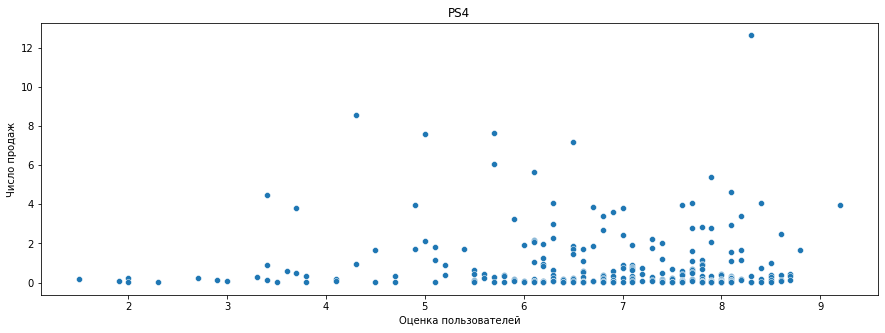

In [44]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='user_score', y='total_sales', data=ps4_actual)
plt.title('PS4')
plt.xlabel('Оценка пользователей')
plt.ylabel('Число продаж')

Рассчитаем корреляцию:

In [45]:
print(ps4_actual['user_score'].corr(ps4_actual['total_sales']))

-0.031957110204556376


Теперь же составим диаграмму рассеивания для зависимости числа продаж от отзывов критиков:

Text(0, 0.5, 'Число продаж')

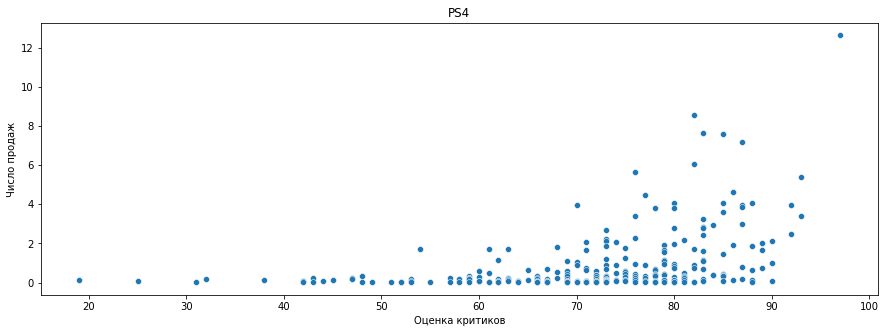

In [46]:
plt.figure(figsize=(15,5))
sns.scatterplot(x='critic_score', y='total_sales', data=ps4_actual)
plt.title('PS4')
plt.xlabel('Оценка критиков')
plt.ylabel('Число продаж')

Рассчитаем корреляцию:

In [47]:
print(ps4_actual['critic_score'].corr(ps4_actual['total_sales']))

0.40656790206178095


В итоге мы видим, что для платформы PS4 есть прямая корреляция между числом продаж и отзывами критиков, но корреляция между продажами и отзывами пользователей выражена очень слабо.

Соотнесем эти выводы с результатами для других успешных платформ. 

Составим диаграммы рассеивания для зависимости числа продаж от отзывов пользователей и рассчитаем корреляцию для каждой из них:

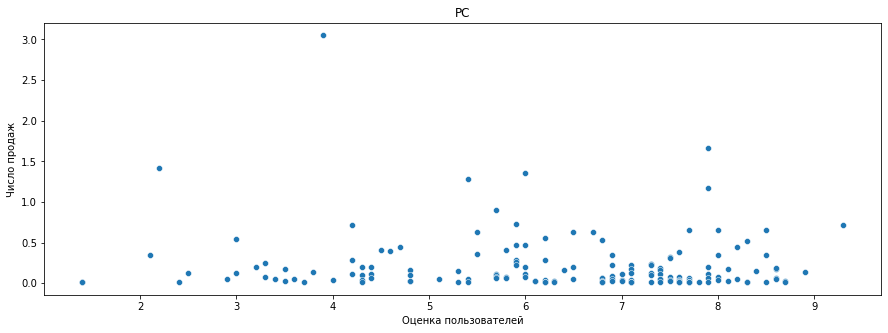

Коэффициент корреляции: -0.0899977567844875


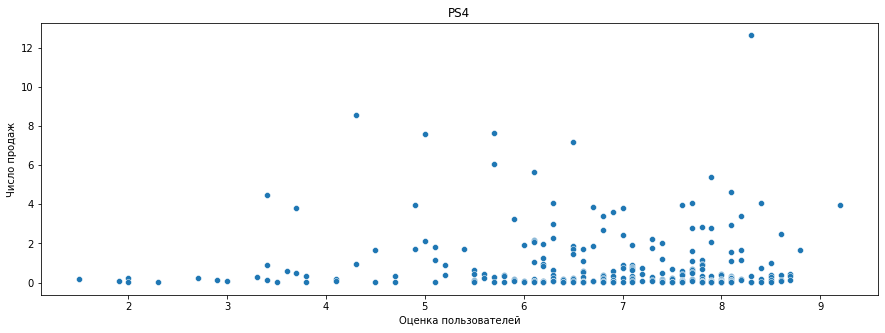

Коэффициент корреляции: -0.031957110204556376


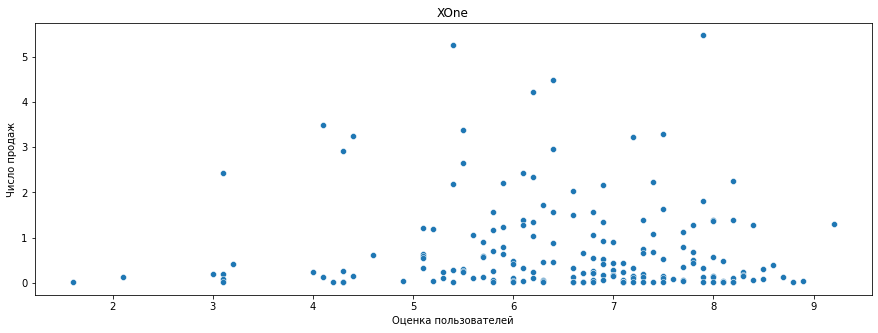

Коэффициент корреляции: -0.06892505328279414


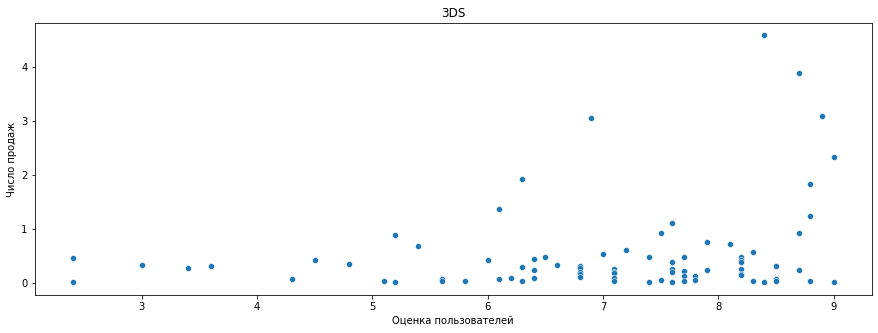

Коэффициент корреляции: 0.24150411773563016


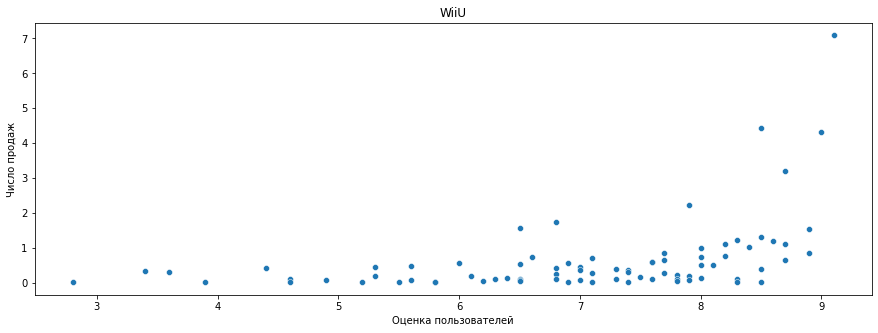

Коэффициент корреляции: 0.4193304819266187


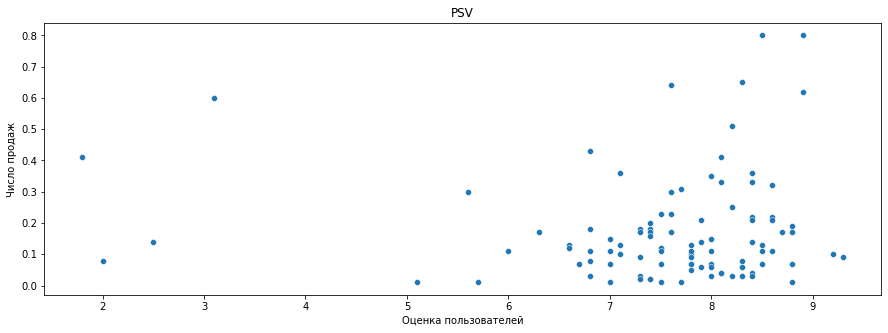

Коэффициент корреляции: 0.0009424723319108626


In [48]:
for plat in top_platforms_actual:
    platform = games_actual[games_actual['platform']==plat]
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='user_score', y='total_sales', data=platform)
    plt.title(plat)
    plt.xlabel('Оценка пользователей')
    plt.ylabel('Число продаж')
    plt.show()
    print('Коэффициент корреляции:', platform['user_score'].corr(platform['total_sales']))

Сделаем все то-же самое, но теперь для зависимости числа продаж от отзывов критиков:

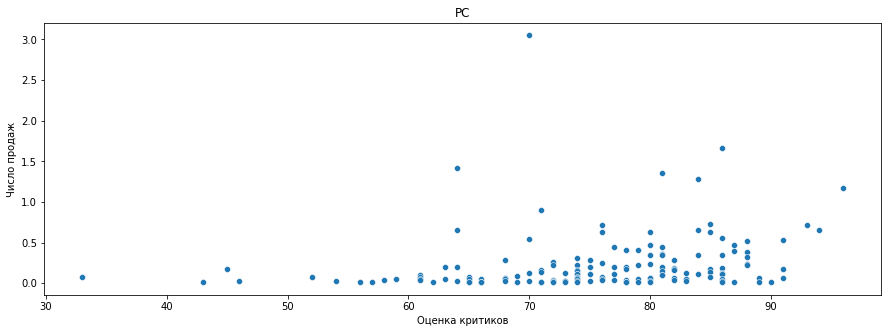

Коэффициент корреляции: 0.19965984836380182


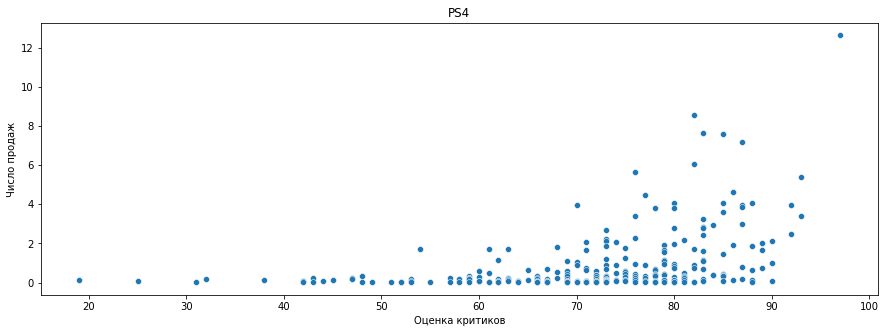

Коэффициент корреляции: 0.40656790206178095


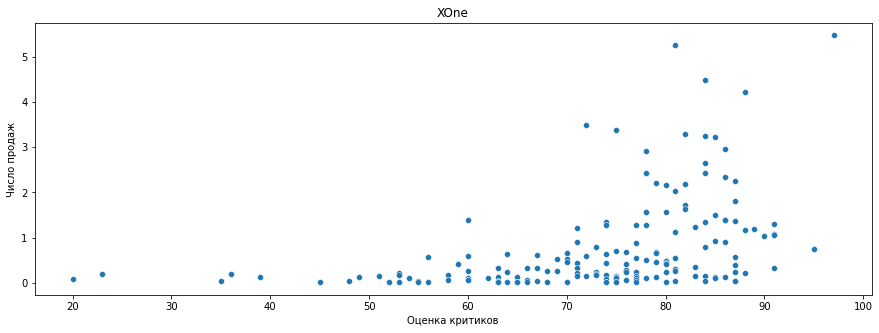

Коэффициент корреляции: 0.4169983280084017


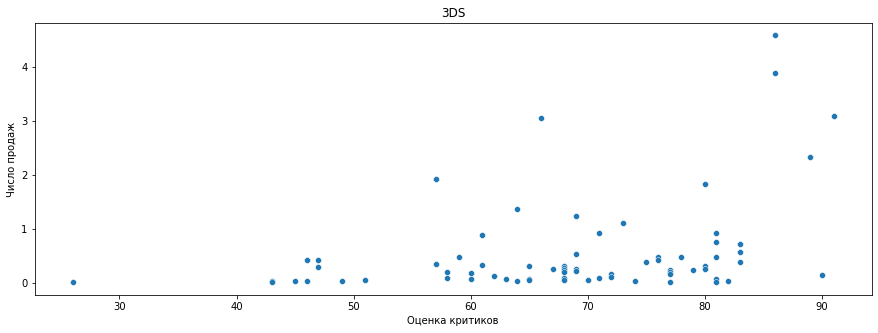

Коэффициент корреляции: 0.3570566142288103


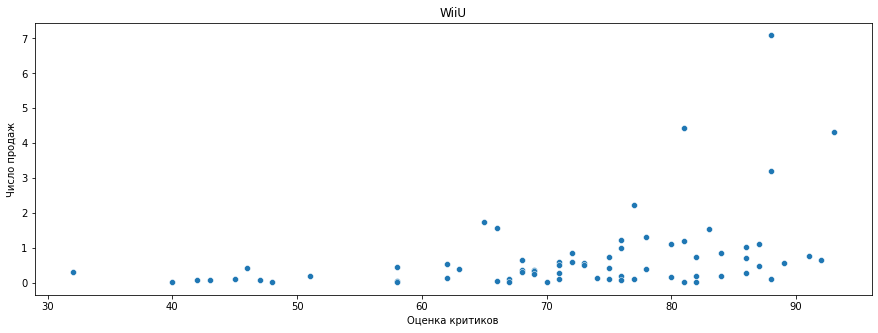

Коэффициент корреляции: 0.3764149065423912


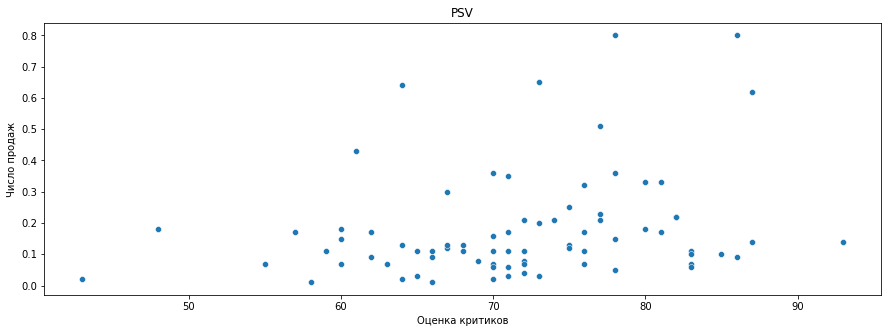

Коэффициент корреляции: 0.2547423503068656


In [49]:
for plat in top_platforms_actual:
    platform = games_actual[games_actual['platform']==plat]
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='critic_score', y='total_sales', data=platform)
    plt.title(plat)
    plt.xlabel('Оценка критиков')
    plt.ylabel('Число продаж')
    plt.show()
    print('Коэффициент корреляции:', platform['critic_score'].corr(platform['total_sales']))

**Выводы:**

1. Для PC:
    * Корреляция между отзывами критиков и числом продаж слабая прямая.
    * Корреляция между отзывами пользователей и числом продаж отсутствует.
2. Для PS4:
    * Корреляция между отзывами критиков и числом продаж средняя прямая.
    * Корреляция между отзывами пользователей и числом продаж отсутствует.
3. Для XOne:
    * Корреляция между отзывами критиков и числом продаж средняя прямая.
    * Корреляция между отзывами пользователей и числом продаж отсутствует.
4. Для 3DS:
    * Корреляция между отзывами критиков и числом продаж средняя прямая.
    * Корреляция между отзывами пользователей и числом продаж слабая прямая.
5. Для WiiU:
    * Корреляция между отзывами критиков и числом продаж средняя прямая.
    * Корреляция между отзывами пользователей и числом продаж средняя прямая.
6. Для PSV:
    * Корреляция между отзывами критиков и числом продаж слабая прямая.
    * Корреляция между отзывами пользователей и числом продаж отсутствует.
    
Мы видим, что PS4 имеет схожие корреляции с PC, XOne и PSV.

### Влияние жанра на число продаж



Посмотрим на распределение игр по жанрам.

Для этого составим сводную таблицу c медианным значением числа продаж и отфильтруем ее:

In [50]:
games_by_genre = games_actual.pivot_table(index='genre', values='total_sales', aggfunc='median').sort_values(
by='total_sales', ascending=False).reset_index()

display(games_by_genre)

,genre,total_sales
0,Shooter,0.450
1,Sports,0.240
2,Platform,0.225
3,Role-Playing,0.125
4,Fighting,0.125
5,Racing,0.120
6,Action,0.110
7,Misc,0.105
8,Simulation,0.100
9,Strategy,0.080


Чтобы данные было проще анализировать, составим по ним диаграмму:

Text(0, 0.5, 'Число продаж')

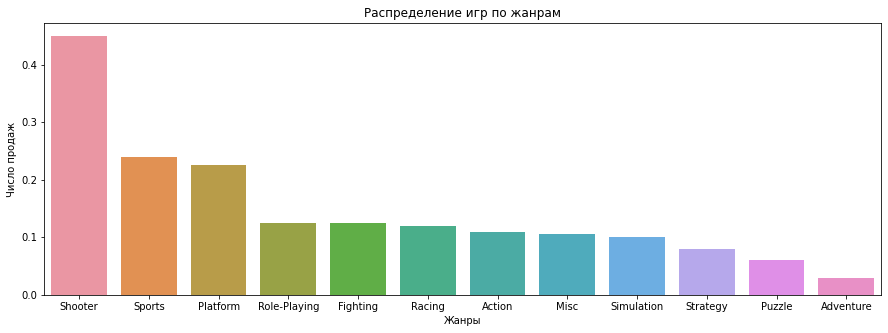

In [51]:
plt.figure(figsize=(15,5))
sns.barplot(data=games_by_genre, x='genre', y='total_sales')
plt.title('Распределение игр по жанрам')
plt.xlabel('Жанры')
plt.ylabel('Число продаж')

**Вывод:**

1. Самые популярными жанрами являются Shooter, Sports и Platform. Жанры Shooter и Platform обязаны своей популярностью своей же простоте в освоении. Жанр Sports же всегда является выбором фанатов реального спорта, которых тоже довольно много.
2. Самыми непопулярными жанрами являются Strategy, Puzzle и Adventure. Судя по всему, большей части игроков не хочется много думать, предпочитая более расслабляющее времяпровождение.

## Портрет пользователей NA, EU, JP

Определим для каждого региона следующее:

* Самые популярные платформы (топ-5).
* Самые популярные жанры (топ-5).
* Влияет ли рейтинг ESRB на продажи в отдельном регионе.

Для начала выделим из таблицы актуального временного периода данные о продажах каждого региона и сохраним их в отдельные датасеты:

In [52]:
na_sales = games_actual.query('na_sales > 0')

eu_sales = games_actual.query('eu_sales > 0')

jp_sales = games_actual.query('jp_sales > 0')

Теперь мы можем приступить к дальнейшему анализу.

### Самые популярные платформы по регионам

Начнем с того, что составим список самых популярных платформ для пользователей Северной Америки:

In [53]:
na_platform_table = na_sales.pivot_table(index='platform', values='na_sales', aggfunc='sum') \
                    .sort_values('na_sales', ascending=False).reset_index()

display(na_platform_table)

,platform,na_sales
0,PS4,108.74
1,XOne,93.12
2,X360,81.66
3,PS3,63.50
4,3DS,38.20
5,WiiU,29.21
6,PC,11.19
7,Wii,6.56
8,PSV,5.04
9,DS,0.57


Для удобства визуализируем на диаграмме:

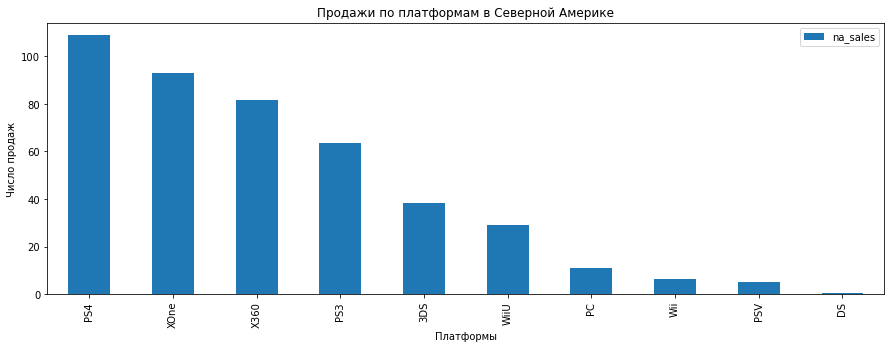

In [54]:
na_platform_table.plot(x='platform', y='na_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по платформам в Северной Америке')
plt.xlabel('Платформы')
plt.ylabel('Число продаж')
plt.show()

Теперь составим список самых популярных платформ для Европы:

In [55]:
eu_platform_table = eu_sales.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).reset_index()

display(eu_platform_table)

,platform,eu_sales
0,PS4,141.09
1,PS3,67.81
2,XOne,51.59
3,X360,42.52
4,3DS,30.96
5,PC,25.84
6,WiiU,19.85
7,PSV,6.10
8,Wii,5.93
9,DS,0.85


Визуализируем:

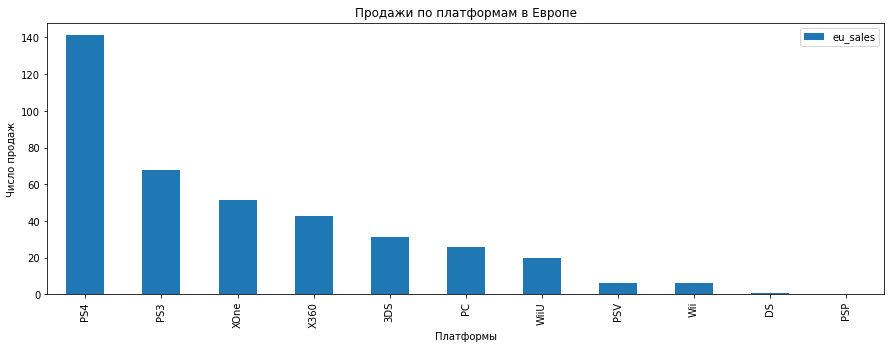

In [56]:
eu_platform_table.plot(x='platform', y='eu_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по платформам в Европе')
plt.xlabel('Платформы')
plt.ylabel('Число продаж')
plt.show()

Наконец, составим список самых популярных платформ для Японии:

In [57]:
jp_platform_table = jp_sales.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).reset_index()

display(jp_platform_table)

,platform,jp_sales
0,3DS,67.81
1,PS3,23.35
2,PSV,18.59
3,PS4,15.96
4,WiiU,10.88
5,PSP,3.53
6,X360,0.51
7,XOne,0.34
8,Wii,0.05


Визуализируем:

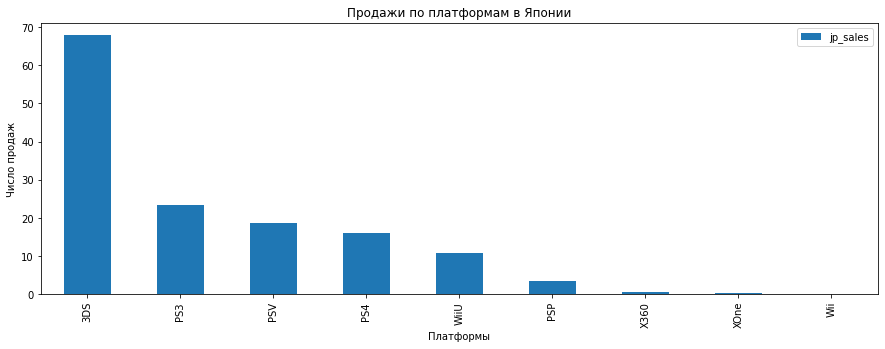

In [58]:
jp_platform_table.plot(x='platform', y='jp_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по платформам в Японии')
plt.xlabel('Платформы')
plt.ylabel('Число продаж')
plt.show()

**Выводы:**

1. Пятерка самых популярных платформ по региону:
* В Северной Америке: PS4, XOne, X360, PS3, 3DS.
* В Европе: PS4, PS3, XOne, X360, 3DS.
* В Японии: 3DS, PS3, PSV, PS4, WiiU.
    
2. Мы видим, что на рынке Северной Америки идет плавный спад популярности для каждой последующей в списке платформы. Для двух других регионов картина не такая гладкая.

3. В Европе PS4 занимает лидирующее положение среди всех платформ, превысив своего предшественника PS3 в популярности на 75 млн проданных копий, а своего ближайшего конкурента XOne на 95 млн. 

4. На рынке Японии же полностью доминирует платформа 3DS, обойдя ближайшего соперника почти на 50 млн копий в продажах. Это объясняется фаворитизмом Японии к своему домашнему производителю Nintendo. 

### Самые популярные жанры по регионам

Как и в предыдущем пункте, составим списки самых популярных жанров для каждого из исследуемых регионов, и визуализируем их на диаграмме для удобства.

Начнем с Северной Америки:

In [59]:
na_genre_table = na_sales.pivot_table(index='genre', values='na_sales', aggfunc='median').sort_values('na_sales', ascending=False).reset_index()

display(na_genre_table)

,genre,na_sales
0,Sports,0.270
1,Shooter,0.220
2,Misc,0.130
3,Platform,0.110
4,Action,0.100
5,Strategy,0.100
6,Fighting,0.095
7,Puzzle,0.090
8,Role-Playing,0.090
9,Simulation,0.075


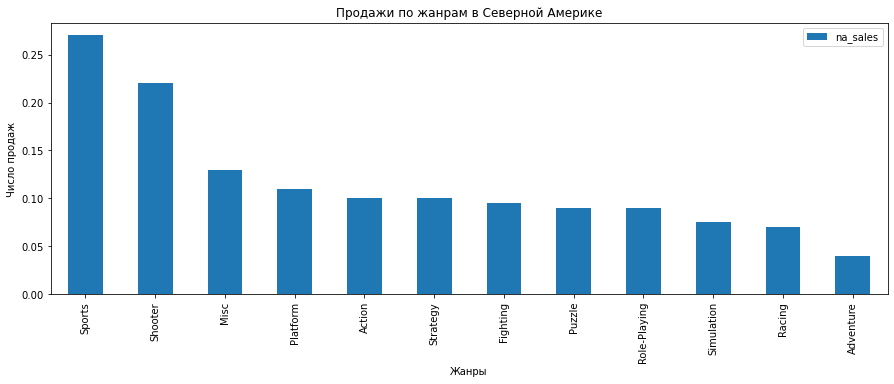

In [60]:
na_genre_table.plot(x='genre', y='na_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по жанрам в Северной Америке')
plt.xlabel('Жанры')
plt.ylabel('Число продаж')
plt.show()

Теперь рассмотрим данные по Европе:

In [61]:
eu_genre_table = eu_sales.pivot_table(index='genre', values='eu_sales', aggfunc='median').sort_values('eu_sales', ascending=False).reset_index()

display(eu_genre_table)

,genre,eu_sales
0,Shooter,0.230
1,Platform,0.120
2,Racing,0.090
3,Sports,0.090
4,Misc,0.085
5,Action,0.080
6,Simulation,0.080
7,Strategy,0.080
8,Fighting,0.070
9,Role-Playing,0.070


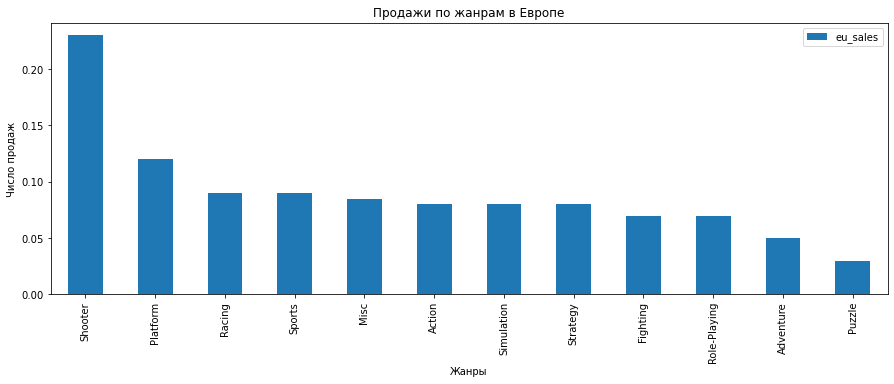

In [62]:
eu_genre_table.plot(x='genre', y='eu_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по жанрам в Европе')
plt.xlabel('Жанры')
plt.ylabel('Число продаж')
plt.show()

Наконец, сделаем то-же самое для Японии:

In [63]:
jp_genre_table = jp_sales.pivot_table(index='genre', values='jp_sales', aggfunc='median').sort_values('jp_sales', ascending=False).reset_index()

display(jp_genre_table)

,genre,jp_sales
0,Puzzle,0.085
1,Role-Playing,0.070
2,Sports,0.070
3,Misc,0.060
4,Strategy,0.060
5,Platform,0.055
6,Fighting,0.050
7,Action,0.040
8,Shooter,0.040
9,Simulation,0.040


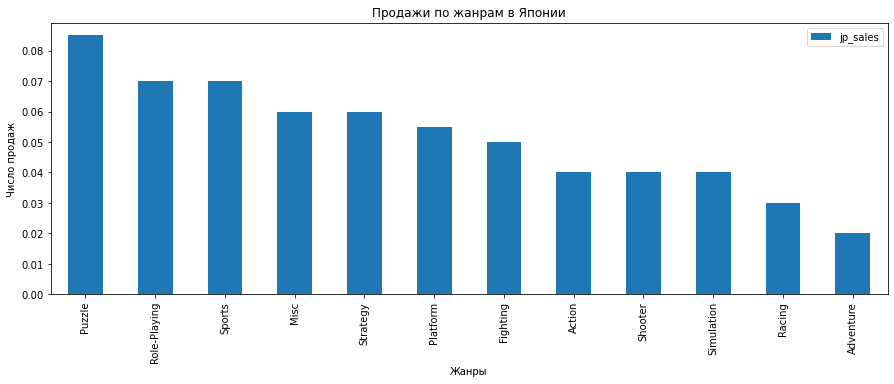

In [64]:
jp_genre_table.plot(x='genre', y='jp_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по жанрам в Японии')
plt.xlabel('Жанры')
plt.ylabel('Число продаж')
plt.show()

**Выводы:**

1. Пятерка самых популярных жанров:
* В Северной Америке: Sports, Shooter, Misc, Platform, Action.
* В Европе: Shooter, Platform, Racing, Sports, Misc.
* В Японии: Puzzle, Role-Playing, Sports, Misc, Strategy.

2. Мы видим, что двумя самыми популярными жанрами в Северной Америке с большим отрывом являются Sports и Shooter. Судя по всему, Европа полна спортивных фанатов, а стрелялки всегда помогут спустить пар от проигрыша любимой команды.
3. Европа обладает почти такими же жанрами в лидирующих позициях, за исключением жанра Racing. Европейцы явно любят красивые машины.
4. В Японии же помимо Sports предпочтение также отдается жанрам, требующих более осмысленного геймплея и/или критического мышления. 
5. Жанр Misc остается популярным вне зависимости от региона, поскольку включает в себя большое множество более мелких под-жанров.

### Влияние рейтинга ESRB на продажи по регионам

Чтобы последующие данные было проще понять, расшифруем, какую возрастную категорию обозначает каждая абревиатура рейтинга ESRB:

* **E** (Everyone) - Для всех возрастов.
* **E10+** (Everyone 10+) - От 10 лет и выше.
* **T** (Teen) - От 13 лет и выше.
* **M** (Mature) - От 17 лет и выше.

Составим таблицу с суммой продаж по рейтингу ESRB для региона Северной Америки:

In [65]:
na_rating_table = na_sales.pivot_table(index='rating', values='na_sales', aggfunc='sum').sort_values('na_sales', ascending=False).reset_index()

display(na_rating_table)

,rating,na_sales
0,M,165.29
1,NR,89.42
2,E,79.05
3,E10+,54.24
4,T,49.79


Визуализируем для удобства:

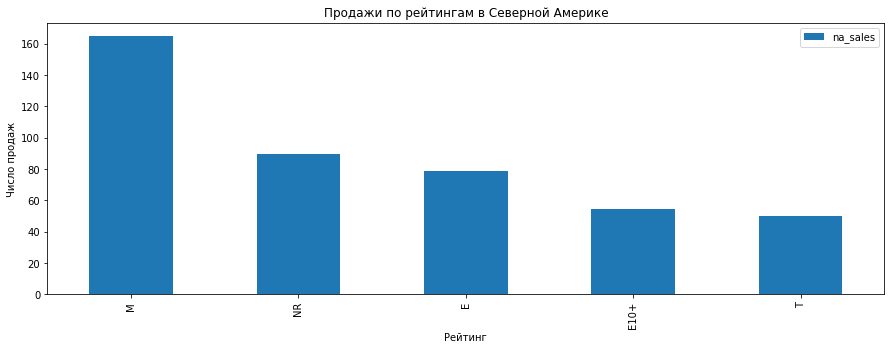

In [66]:
na_rating_table.plot(x='rating', y='na_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по рейтингам в Северной Америке')
plt.xlabel('Рейтинг')
plt.ylabel('Число продаж')
plt.show()

Повторим для Европы:

In [67]:
eu_rating_table = eu_sales.pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values('eu_sales', ascending=False).reset_index()

display(eu_rating_table)

,rating,eu_sales
0,M,145.80
1,E,83.36
2,NR,78.91
3,E10+,42.69
4,T,41.95


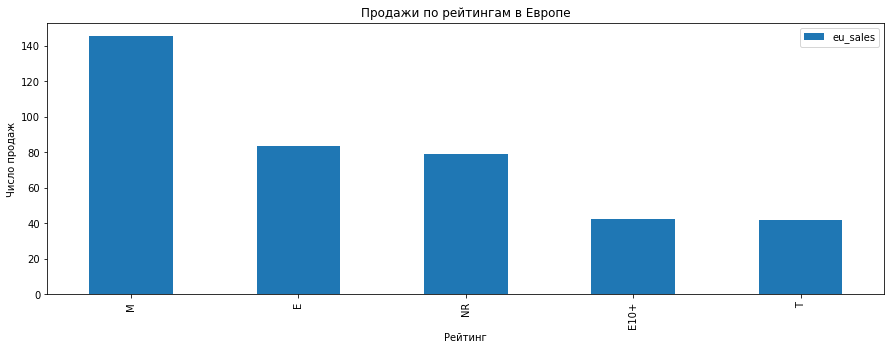

In [68]:
eu_rating_table.plot(x='rating', y='eu_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по рейтингам в Европе')
plt.xlabel('Рейтинг')
plt.ylabel('Число продаж')
plt.show()

Наконец, для Японии:

In [69]:
jp_rating_table = jp_sales.pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values('jp_sales', ascending=False).reset_index()

display(jp_rating_table)

,rating,jp_sales
0,NR,85.29
1,T,20.59
2,E,15.14
3,M,14.11
4,E10+,5.89


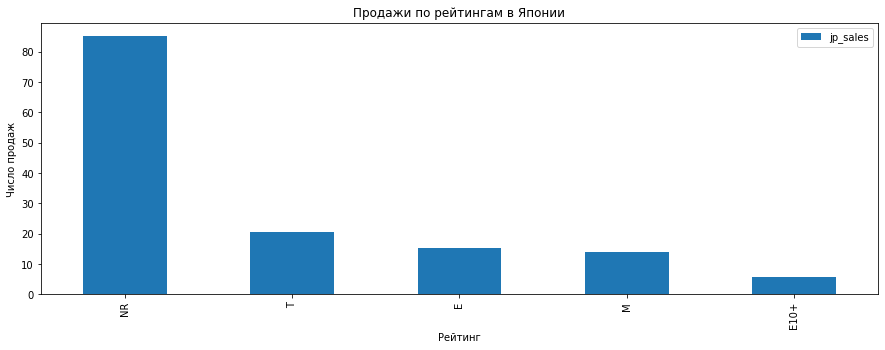

In [70]:
jp_rating_table.plot(x='rating', y='jp_sales', kind='bar', figsize=(15, 5))
plt.title('Продажи по рейтингам в Японии')
plt.xlabel('Рейтинг')
plt.ylabel('Число продаж')
plt.show()

**Вывод:**

1. Мы видим, что популярность игр с определенным рейтингом в Америке и Европе почти одинаковая: лидируют игры с рейтингом 17+. 
2. В Японии же самыми распространенными играми являются игры без рейтинга. Скорее всего потому что подавляющее большинство игр, популярных в Японии - локального производства, которые никогда не выпускались и не локализировались в иностранных рынках.
3. Рейтинг ESRB имеет влияние на продажи в отдельных регионах.

## Проверка гипотез

От нас требуется проверить следующие гипотезы:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
2. Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Мы достаточно детально проанализировалли все предоставленные данные, и можем теперь приступить к проверке поставленных гипотез.

### Средние пользовательские рейтинги платформ Xbox One и PC

Определим нулевую и альтернативную гипотезы:
* H0: Cредние пользовательские рейтинги платформ X360 и PС одинаковые.
* H1: Cредние пользовательские рейтинги платформ X360 и PС различаются.

Поскольку генеральных совокупностей у нас две, для проверки нулевой гипотезы мы будем использовать метод ttest_ind().

Сохраним интересующие нас данные из актуального временного периода в отдельные переменные:

In [71]:
user_rating_xone = games_actual.query('platform == "XOne"')['user_score'].dropna()

user_rating_pc = games_actual.query('platform == "PC"')['user_score'].dropna()

Посмотрим средние значения для каждой выборки:

In [72]:
print('Среднее значение Xone:', user_rating_xone.mean())
print('Среднее значение PC:', user_rating_pc.mean())

Среднее значение Xone: 6.52142857142857
Среднее значение PC: 6.2803797468354405


Произведем проверку дисперсии выборок:

In [73]:
print('Дисперсия для XOne:', np.var(user_rating_xone))
print('Дисперсия для PC:', np.var(user_rating_pc))

Дисперсия для XOne: 1.8965188383045533
Дисперсия для PC: 2.9913239064252517


Хоть средние значения и почти одинаковы, дисперсия явно различается. 

Параметр equal_var зададим как False. 

Пороговое значение alpha зададим, как равное 1%.

In [74]:
alpha = 0.01

results = st.ttest_ind(user_rating_xone, user_rating_pc, equal_var=False)

print('P-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

P-значение: 0.16174359801784308
Не получилось отвергнуть нулевую гипотезу.


**Вывод:**

Поскольку нулевую гипотезу отвергнуть не удалось, у нас нет оснований утверждать, что средние пользовательские рейтинги платформ Xbox One и PC значимо различаются.

### Средние пользовательские рейтинги жанров Action и Sports

Определим нулевую и альтернативные гипотезы:
* H0: Средние пользовательские рейтинги жанров Action и Sports одинаковые.
* H1: Средние пользовательские рейтинги жанров Action и Sports различаются.

Поскольку генеральных совокупностей у нас две, для проверки нулевой гипотезы мы будем использовать метод ttest_ind().

Сохраним интересующие нас данные из актуального временного периода в отдельные переменные:

In [75]:
user_rating_action = games_actual.query('genre == "Action"')['user_score'].dropna()

user_rating_sports = games_actual.query('genre == "Sports"')['user_score'].dropna()

Просмотрим средние значения для каждой выборки:

In [76]:
print('Среднее значение Action:', user_rating_action.mean())
print('Среднее значение Sports:', user_rating_sports.mean())

Среднее значение Action: 6.837500000000005
Среднее значение Sports: 5.238124999999999


Произведем проверку дисперсии выборок:

In [77]:
print('Дисперсия для Action:', np.var(user_rating_action))
print('Дисперсия для Sports:', np.var(user_rating_sports))

Дисперсия для Action: 1.761935586734693
Дисперсия для Sports: 3.1607339843749975


По статистическим данным здесь отличается все. 

Параметр equal_var зададим как False.

Пороговое значение alpha зададим, как равное 1%.

In [78]:
alpha = 0.01

results = st.ttest_ind(user_rating_action, user_rating_sports, equal_var=False)

print('P-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу.")
else:
    print("Не получилось отвергнуть нулевую гипотезу.")

P-значение: 1.3883444596405356e-20
Отвергаем нулевую гипотезу.


**Вывод:**

Поскольку мы отвергли нулевую гипотезу, у нас есть достаточно оснований утверждать, что средние пользовательские рейтинги жанров Action и Sports значимо различаются.

## Общий вывод

1. В процессе изучения и предобработки данных, мы внесли в таблицу следующие изменения:
* year_of_release - тип данных поменяли на int.
* user_score - заменили tbd на NaN, и тип данных поменяли на float.
* Удалили пропущенные значения в столбцах name, genre, year_of_release.
* Удалили неявные дубликаты в 4106 и 16087 строках.
* Добавили столбец total_sales с суммарными продажами во всех регионах.

2. Во время исследовательского анализа данных, мы пришли к следующим заключениям:
    1. Мы изучили распределение выпуска игр в разные годы, и пришли к выводу, что продажи за весь период нас не интересуют.
    2. Мы обнаружили, что платформы с самыми большими суммарными продажами за весь период являются: PS2, X360, PS3, Wii, DS и PS. Мы построили распределение по продажам по годам для каждой из них. В результате было выявлено, что средний срок жизни платформы составляет 11 лет. 
    3. Актуальный период для дальнейших исследований на основе предыдущих наблюдений было решено постановить с 2013 по 2016 год. Данные за предыдущие годы далее учитываться не будут.
    4. Исследовав данные за актуальный период, было постановленно, что самыми многообещающими платформами являются PC, PS4, XOne, 3DS, WiiU и PSV. Для каждой из них был составлен "ящик с усами" по глобальным продажам. Результат следующий:
        * Среднее число продаж на PC на одну игру составляет 208 тыс. копий. Максимальное число продаж: 3.1 млн. копий.
        * Среднее число продаж на PS4 на одну игру составляет 801 тыс. копий. Максимальное число продаж: 14.6 млн. копий.
        * Среднее число продаж на XOne на одну игру составляет 645 тыс. копий. Максимальное число продаж: 7.4 млн. копий.
        * Среднее число продаж на 3DS на одну игру составляет 472 тыс. копий. Максимальное число продаж: 14.6 млн. копий.
        * Среднее число продаж на WiiU на одну игру составляет 562 тыс. копий. Максимальное число продаж: 7.1 млн. копий.
        * Среднее число продаж на PSV на одну игру составляет 92 тыс. копий. Максимальное число продаж: 2 млн. копий.
    
    5. Мы изучили влияние отзывов пользователей и критиков на число продаж для платформ, построили диаграмму рассеяния и посчитали корреляцию между отзывами и продажами для них. Результат следующий:
        * Для PC:
            - Корреляция между отзывами критиков и числом продаж слабая прямая.
            - Корреляция между отзывами пользователей и числом продаж отсутствует.
        * Для PS4:
            - Корреляция между отзывами критиков и числом продаж средняя прямая.
            - Корреляция между отзывами пользователей и числом продаж отсутствует.
        * Для XOne:
            - Корреляция между отзывами критиков и числом продаж средняя прямая.
            - Корреляция между отзывами пользователей и числом продаж отсутствует.
        * Для 3DS:
            - Корреляция между отзывами критиков и числом продаж средняя прямая.
            - Корреляция между отзывами пользователей и числом продаж слабая прямая.
        * Для WiiU:
            - Корреляция между отзывами критиков и числом продаж средняя прямая.
            - Корреляция между отзывами пользователей и числом продаж средняя прямая.
        * Для PSV:
            - Корреляция между отзывами критиков и числом продаж слабая прямая.
            - Корреляция между отзывами пользователей и числом продаж отсутствует.    
        
    6. Мы изучили влияние жанра на число продаж для платформ, составили диаграмму распределения. Выводы следующие:
        * Самые популярными жанрами являются Shooter, Sports и Platform. 
        * Самыми непопулярными жанрами являются Strategy, Puzzle и Adventure.
3. Мы составили портрет для пользователей трех регионов: NA, EU и JP. Итоги следующие:
    * Пятерка самых популярных платформ по региону:
        * В Северной Америке: PS4, XOne, X360, PS3, 3DS.
        * В Европе: PS4, PS3, XOne, X360, 3DS.
        * В Японии: 3DS, PS3, PSV, PS4, WiiU.
    * Пятерка самых популярных жанров:
        * В Северной Америке: Sports, Shooter, Misc, Platform, Action.
        * В Европе: Shooter, Platform, Racing, Sports, Misc.
        * В Японии: Puzzle, Role-Playing, Sports, Misc, Strategy.
    * Популярность игр с определенным рейтингом в Америке и Европе почти одинаковая: лидируют игры с рейтингом 17+. В Японии же самыми распространенными играми являются игры без рейтинга, поскольку большинство игр там не локализируются на американский рынок.
    
4. Мы проверили две поставленные гипотезы, и пришли к следующим заключениям:
    * Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
    * Средние пользовательские рейтинги жанров Action и Sports разные.